In [ ]:
from helper import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import distance_transform_edt, label, binary_closing, binary_propagation, binary_dilation
from scipy.ndimage import gaussian_filter
from skimage.morphology import convex_hull_image
from skimage.morphology import skeletonize_3d
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
import SimpleITK as sitk

This notebook demonstrates the semi-automatic pipeline for colon segmentation.

In [2]:
path = "/Users/dariavasile/Downloads/"
subject = "sub426"
position = "supine"

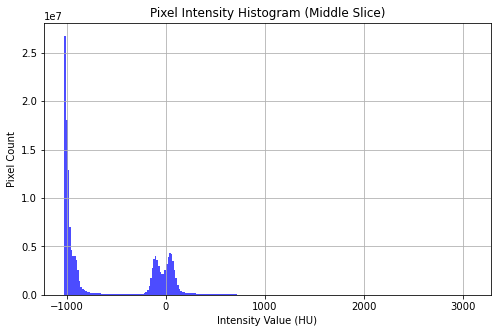

In [3]:
# Load image
full_path = f"{path}{subject}_pos-{position}_scan-1_conv-sitk.mha"
image = load_mha_file(full_path)

# Plot the histogram of pixel intensities
plt.figure(figsize=(8, 5))
plt.hist(image.flatten(), bins=256, color='blue', alpha=0.7)
plt.title("Pixel Intensity Histogram (Middle Slice)")
plt.xlabel("Intensity Value (HU)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.show()

### 1. Remove outside air

In [ ]:
air_threshold = -500  

air_mask = image < air_threshold  

# Define seed points in 3D corners 
seeds = [(0, 0, 0), (0, 0, image.shape[2] - 1), 
         (0, image.shape[1] - 1, 0), (0, image.shape[1] - 1, image.shape[2] - 1),
         (image.shape[0] - 1, 0, 0), (image.shape[0] - 1, 0, image.shape[2] - 1), 
         (image.shape[0] - 1, image.shape[1] - 1, 0), (image.shape[0] - 1, image.shape[1] - 1, image.shape[2] - 1)]

labeled_mask, num_features = ndimage.label(air_mask)

# Create an empty mask for region growing
air_region = np.zeros_like(air_mask, dtype=bool)

# Perform region growing from each seed
for seed in seeds:
    label_value = labeled_mask[seed]  # Get the label value at the seed point
    air_region |= labeled_mask == label_value  # Add connected air regions

# Remove external air by setting it to white (max intensity of image)
image_cleaned = image.copy()
image_cleaned[air_region] = np.max(image)

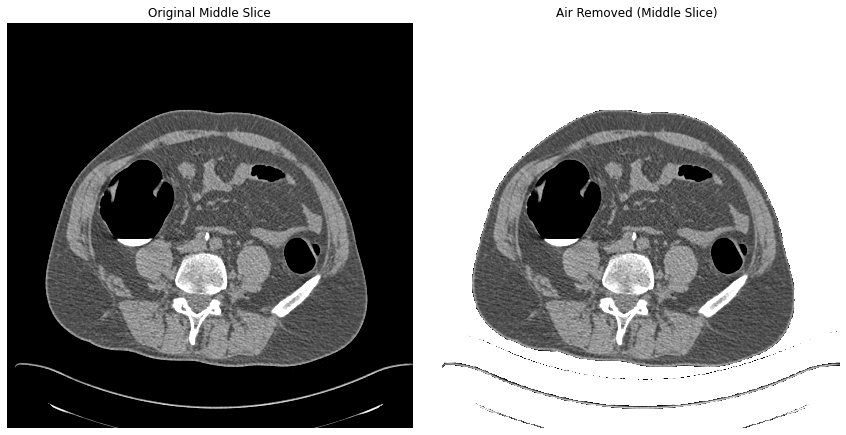

In [5]:
# Display a sample middle slice before and after processing
mid_index = image.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image[mid_index, :, :], cmap='gray', vmin=-300, vmax=300)
axes[0].set_title("Original Middle Slice")
axes[0].axis("off")

axes[1].imshow(image_cleaned[mid_index, :, :], cmap='gray', vmin=-300, vmax=300)
axes[1].set_title("Air Removed (Middle Slice)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("step1.png")
plt.show()

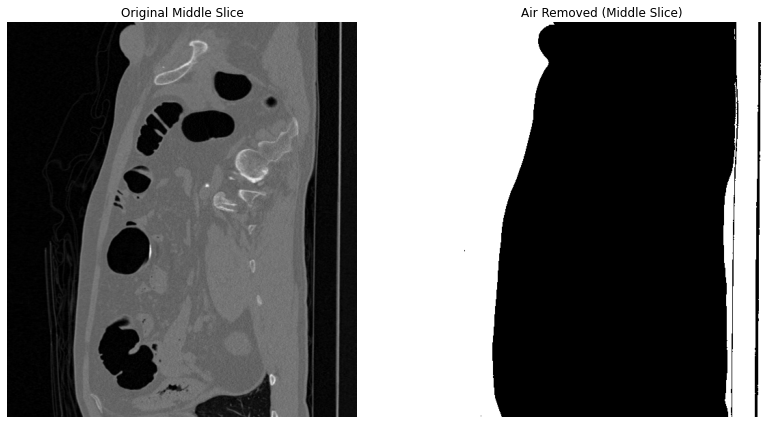

In [6]:
# Display a sample middle slice before and after processing
mid_index = image.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image[:, :, mid_index], cmap='gray')
axes[0].set_title("Original Middle Slice")
axes[0].axis("off")

axes[1].imshow(air_region[:, :, mid_index], cmap='gray')
axes[1].set_title("Air Removed (Middle Slice)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### 2. Remove bed

In [7]:
labeled_mask, num_features = ndimage.label(air_region == 0)  # Identify black regions

# Compute the size of each component
component_sizes = np.array(ndimage.sum(air_region == 0, labeled_mask, range(num_features + 1)))

# Sort components by size (descending order)
sorted_components = np.argsort(-component_sizes)

# Identify the second-largest black component
largest_component = sorted_components[0]  # Background air (should remain)
second_largest_component = sorted_components[1]  # The unwanted region

# Create a 3D mask for the second-largest black component
bottom_object_mask = labeled_mask == second_largest_component


In [8]:
# Print sorted component sizes
# print("Component sizes (sorted, descending):", np.sort(component_sizes)[::-1])

# Print the size of the second-largest component
print("Size of second-largest component:", component_sizes[sorted_components[1]])


Size of second-largest component: 1226714.0


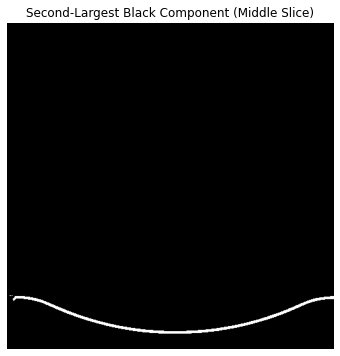

In [9]:
# Create a mask for the second-largest component
second_largest_mask = labeled_mask == sorted_components[1]  # Second-largest component

# Display a middle slice of the detected second-largest component
mid_index = image.shape[0] // 2  

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(second_largest_mask[mid_index, :, :], cmap='gray')
ax.set_title("Second-Largest Black Component (Middle Slice)")
ax.axis("off")

plt.show()


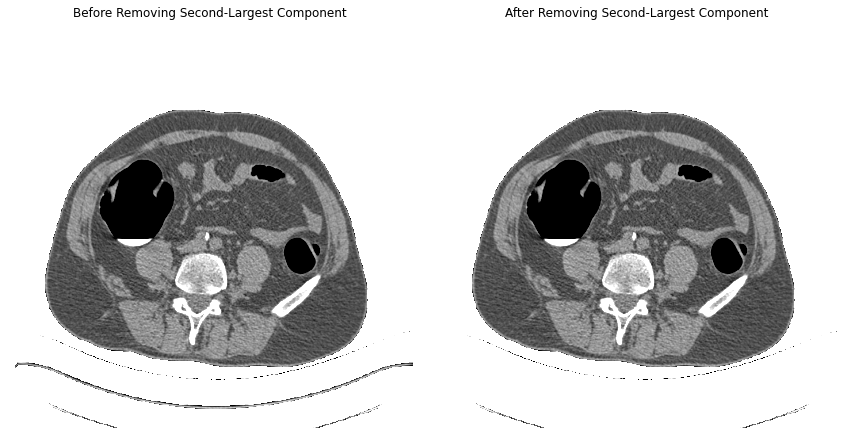

In [ ]:
# Remove the second-largest component from the image by setting it to white
image_final = image_cleaned.copy()
image_final[second_largest_mask] = np.max(image_cleaned)  

# Display a middle slice before and after removal
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_cleaned[mid_index, :, :], cmap='gray', vmin=-300, vmax=300)
axes[0].set_title("Before Removing Second-Largest Component")
axes[0].axis("off")

axes[1].imshow(image_final[mid_index, :, :],cmap='gray', vmin=-300, vmax=300)
axes[1].set_title("After Removing Second-Largest Component")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### 3. Remove lungs

In [11]:
# Use Total Segmentator masks
lower_lobe_left = load_mha_file(f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-lung_lower_lobe_left.mha")
lower_lobe_right = load_mha_file(f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-lung_lower_lobe_right.mha")
middle_lobe_right = load_mha_file(f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-lung_middle_lobe_right.mha")
upper_lobe_left = load_mha_file(f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-lung_upper_lobe_left.mha")
upper_lobe_right = load_mha_file(f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-lung_upper_lobe_right.mha")


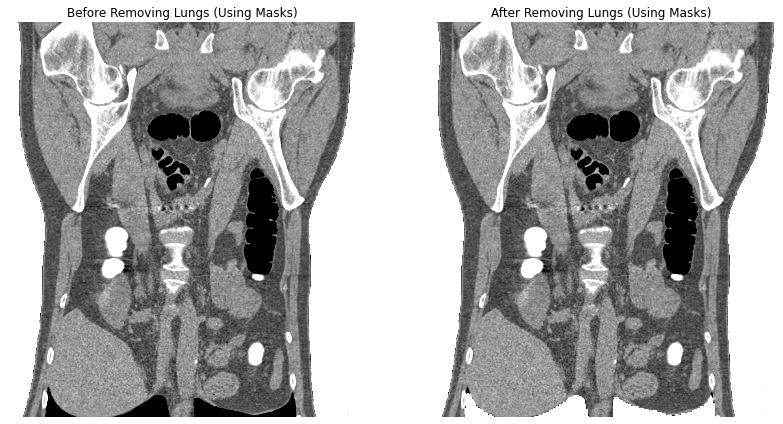

In [ ]:
# Combine all lung lobes into one mask
lungs_mask = (lower_lobe_left > 0) | (lower_lobe_right > 0) | \
             (middle_lobe_right > 0) | (upper_lobe_left > 0) | (upper_lobe_right > 0)

# Apply the mask to remove lungs from the image
image_no_lungs = image_final.copy()
image_no_lungs[lungs_mask] = np.max(image_final)  # Set lungs to white

# Display a middle slice before and after lung removal
mid_index = image_final.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_final[:, mid_index,  :], cmap='gray', vmin=-300, vmax=300)
axes[0].set_title("Before Removing Lungs (Using Masks)")
axes[0].axis("off")

axes[1].imshow(image_no_lungs[:, mid_index,  :], cmap='gray', vmin=-300, vmax=300)
axes[1].set_title("After Removing Lungs (Using Masks)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### 4. Segment Air

In [18]:
air_threshold = -500  
air_mask = image_no_lungs < air_threshold

# Label connected components (air-filled structures)
labeled_mask, num_features = ndimage.label(air_mask)
component_sizes = np.array(ndimage.sum(air_mask, labeled_mask, range(num_features + 1)))

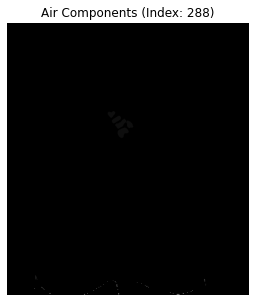

In [19]:
middle_slice_index = labeled_mask.shape[0] // 2
plt.figure(figsize=(10, 5))
plt.imshow(labeled_mask[:, mid_index, :], cmap='gray')
plt.title(f'Air Components (Index: {middle_slice_index})')
plt.axis('off')
plt.show()

In [20]:
colon_path = f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-colon.mha"
colon_mask_ts = load_mha_file(colon_path)

path_small_bowel = f"{path}{subject}_pos-{position}_scan-1_conv-sitk_totalseg-small_bowel.mha"
small_bowel_mask_ts = load_mha_file(path_small_bowel)

In [ ]:
kernel_size = (3, 3, 3)  
structuring_element = np.ones(kernel_size)

kernel_size_colon = (2, 2, 2) 
structuring_element_colon = np.ones(kernel_size)

# Apply binary erosion to the colon mask
eroded_colon_mask = ndimage.binary_erosion(colon_mask_ts, structure=structuring_element_colon)

# Apply dilation on small bowel mask
dilated_small_bowel_mask = ndimage.binary_dilation(small_bowel_mask_ts, structure=structuring_element)
dilated_small_bowel_mask = ndimage.binary_closing(dilated_small_bowel_mask, structure=structuring_element)

In [ ]:
#Set a threshold to ignore very small components
size_threshold = 1000
filtered_air_mask = np.zeros_like(labeled_mask, dtype=bool)

for label in range(1, num_features + 1):  # Skip background (label 0)
    if component_sizes[label] > size_threshold:
        filtered_air_mask |= (labeled_mask == label)

# Re-label only the remaining large components (after removing the very small ones)
filtered_labeled_mask, new_num_features = ndimage.label(filtered_air_mask)

# Compute overlap with the dilated colon mask
overlap_ratios_colon = np.zeros(new_num_features + 1)
overlap_ratios_small_bowel = np.zeros(new_num_features + 1)
overlapping_components = 0

for label in range(1, new_num_features + 1):  # Skip background (label 0)
    component = (filtered_labeled_mask == label)
    
    # Calculate intersection with the dilated colon mask
    intersection_colon = np.sum(component & eroded_colon_mask)
    intersection_small_bowel = np.sum(component & dilated_small_bowel_mask)
    
    # Calculate overlap ratio (intersection / component size)
    component_size = np.sum(component)
    overlap_ratios_colon[label] = intersection_colon / component_size if component_size > 0 else 0
    overlap_ratios_small_bowel[label] = intersection_small_bowel / component_size if component_size > 0 else 0

In [ ]:
def check_shape(component_mask): 
    # Get coordinates of the component's nonzero pixels
    y_indices, x_indices, z_indices = np.where(component_mask)

    if len(y_indices) == 0:
        return 0  # Default to intestine

    # Compute bounding box size
    min_y, max_y = np.min(y_indices), np.max(y_indices)
    min_x, max_x = np.min(x_indices), np.max(x_indices)

    height = max_y - min_y + 1
    width = max_x - min_x + 1

    elongation_ratio = height / width if width > 0 else 1
    if elongation_ratio > 5.5:  
        return 0  
    
    # print("Elongation: ", elongation_ratio)
    
    solidity_values = []

    # Axial view
    for slice_idx in range(component_mask.shape[0]):
        slice_mask = component_mask[slice_idx, :, :]
        if np.sum(slice_mask) == 0:
            continue
        chull = convex_hull_image(slice_mask)
        solidity_values.append(np.sum(slice_mask) / np.sum(chull) if np.sum(chull) > 0 else 0)

    #Coronal View
    for slice_idx in range(component_mask.shape[1]):
        slice_mask = component_mask[:, slice_idx, :]
        if np.sum(slice_mask) == 0:
            continue
        chull = convex_hull_image(slice_mask)
        solidity_values.append(np.sum(slice_mask) / np.sum(chull) if np.sum(chull) > 0 else 0)

    # Sagittal View
    for slice_idx in range(component_mask.shape[2]):
        slice_mask = component_mask[:, :, slice_idx]
        if np.sum(slice_mask) == 0:
            continue
        chull = convex_hull_image(slice_mask)
        solidity_values.append(np.sum(slice_mask) / np.sum(chull) if np.sum(chull) > 0 else 0)

    avg_solidity = np.mean(solidity_values) if solidity_values else 0

    # print("Solidity: ", avg_solidity)
    strict_solidity = (avg_solidity > 0.5)  

    if strict_solidity:
        return 1  # Colon
    return 0  # Intestine

In [ ]:
def check_position(component_mask, colon_intestine_mask, radius_factor=0.25, spread_threshold=0.3):
    shape = colon_intestine_mask.shape
    center_z = shape[0] // 2
    center_y = shape[1] // 2  
    center_x = shape[2] // 2

    image_width = shape[1]
    radius = image_width * radius_factor  
    
    # Find component points
    comp_x, comp_y, comp_z = np.where(component_mask)
    total_points = len(comp_z)

    # Get number of points within the circle
    distances = np.sqrt((comp_z - center_z) ** 2 + (comp_x - center_x) ** 2 + (comp_y - center_y) ** 2)
    inside_circle = np.sum(distances < radius)
    total_points = len(comp_y)
    centrality_score = inside_circle / total_points if total_points > 0 else 0

    spread_x = (np.max(comp_x) - np.min(comp_x)) / shape[1] if total_points > 0 else 0
    spread_y = (np.max(comp_y) - np.min(comp_y)) / shape[2] if total_points > 0 else 0
    spread_z = (np.max(comp_z) - np.min(comp_z)) / shape[0] if total_points > 0 else 0

    # print("centrality: ", centrality_score)

    if centrality_score > 0.7:  # Likely intestine
        if max(spread_x, spread_y, spread_z) > spread_threshold:  # But spreads widely, so it's likely colon
            return 1  # COLON
        else:
            return 0  # INTESTINE
    return 1 

In [ ]:
def generate_skeleton(mask):
    binary_mask = (mask > 0).astype(np.uint8)
    binary_mask = binary_fill_holes(binary_mask).astype(np.uint8)
    
    # Generate the skeleton using 3D thinning
    component_skeleton = skeletonize_3d(binary_mask)
    
    return component_skeleton


overlap_threshold = 0.8
min_votes = 3 

final_colon_mask = np.zeros_like(filtered_labeled_mask, dtype=bool)
colon_intestine_mask = (filtered_labeled_mask > 0)

overlapping_components = 0
image_shape = filtered_labeled_mask.shape

print(image_shape)

skeleton = generate_skeleton(colon_mask_ts)

for label in range(1, new_num_features + 1):
    component_mask = (filtered_labeled_mask == label)

    # 1: Overlap Check
    overlap_colon = overlap_ratios_colon[label]
    overlap_small_bowel = overlap_ratios_small_bowel[label]

    if overlap_small_bowel < 0.1:
        
        overlap_check = int(overlap_colon > overlap_threshold)

        # if it doesn't pass the overlap check but it's still substatial and it is a large component => colon 
        if (overlap_colon > 0.6 and not overlap_check and np.sum(component_mask) > 1000000) or overlap_check:
            score = 1
        else:
            score = 0
        
        if overlap_colon > 0.5:
            # 2: Shape Check
            shape_check = check_shape(component_mask)
            
            # 3: Position Check
            position_check = check_position(component_mask, colon_intestine_mask)

            score += position_check + shape_check
            
            # 4: Distance to centerline
            # inverse_skeleton = 1 - skeleton

            # Compute Euclidean Distance Transform (EDT) to nearest skeleton pixel
            distance_transform = distance_transform_edt(skeleton)
            print(distance_transform.shape)

            # Keep distances only for pixels within the mask
            distance_in_mask = distance_transform * component_mask

            component_size = np.sum(component_mask)  # Count nonzero pixels in the component
            median_distance = np.median(distance_in_mask[component_mask > 0])
            normalized_median_distance = median_distance / np.sqrt(component_size)
            print(normalized_median_distance)
            if normalized_median_distance < 0.1:
                score += 1

        if score >= min_votes:  
            print(f"Label: {label} | Score: {score}/4 | Overlap: {overlap_colon:.2f} | Overlap (small bowel): {overlap_small_bowel:.2f}| Shape: {shape_check} | Position: {position_check}")
            print("Component Size:", np.sum(component_mask))

            final_colon_mask |= component_mask
            overlapping_components += 1

print("Number of components classified as colon:", overlapping_components)

(577, 512, 512)
(577, 512, 512)
0.0
Label: 1 | Score: 4/4 | Overlap: 0.93 | Overlap (small bowel): 0.01| Shape: 1 | Position: 1
Component Size: 4688642
Number of components classified as colon: 1


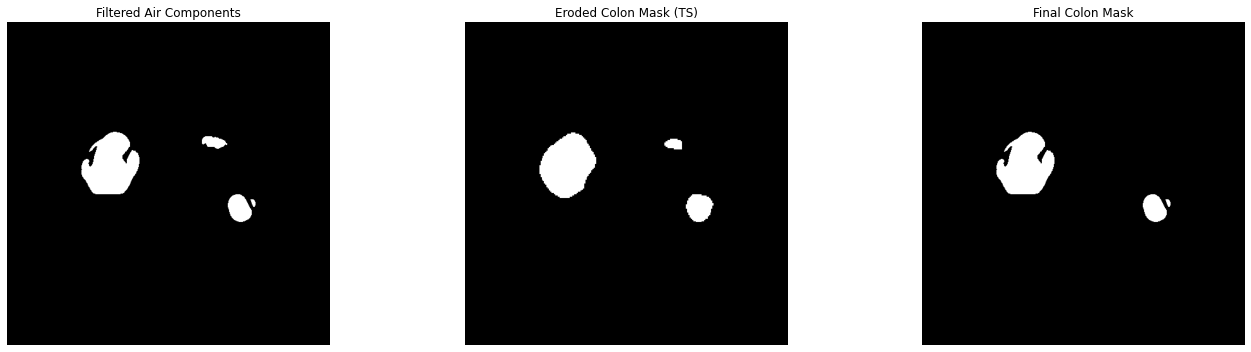

In [29]:
mid_index = image_no_lungs.shape[0] // 2  

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(filtered_air_mask[mid_index, :, :], cmap='gray')
axes[0].set_title("Filtered Air Components")
axes[0].axis("off")

axes[1].imshow(eroded_colon_mask[mid_index, :, :], cmap='gray')
axes[1].set_title("Eroded Colon Mask (TS)")
axes[1].axis("off")

axes[2].imshow(final_colon_mask[mid_index, :, :], cmap='gray')
axes[2].set_title("Final Colon Mask")
axes[2].axis("off")

plt.tight_layout()
plt.savefig("step4_2.png")
plt.show()

#### Retrieve fluid

In [ ]:
def merge_colon_fluid_gap(volume, colon_mask,
                           t_gap_width=2, t_grady=-0.98,
                           min_area=3, min_ecc=0.9, max_flatness=0.45):
    
    zdim, ydim, xdim = volume.shape
    merged_mask = colon_mask.copy()

    for z in range(zdim):
        slice_img = volume[z]
        air_mask = colon_mask[z]  
        fluid_mask = (slice_img > 100) 

        dt_air = distance_transform_edt(np.logical_not(air_mask))
        dt_fluid = distance_transform_edt(np.logical_not(fluid_mask))

        # Y-gradient only (vertical axis)
        grad_air_y = np.gradient(dt_air, axis=0)
        grad_fluid_y = np.gradient(dt_fluid, axis=0)
        dot_product_y = grad_air_y * grad_fluid_y

        # Gap condition: close to both air + fluid, gradients oppose in y-dir
        m1 = dt_air < t_gap_width
        m2 = dt_fluid < t_gap_width
        m3 = dot_product_y < t_grady
        raw_gap = m1 & m2 & m3

        # Filter by shape
        labeled_gap, _ = label(raw_gap)
        final_gap_mask = np.zeros_like(raw_gap, dtype=bool)
        for region in regionprops(labeled_gap):
            if region.area >= min_area and region.eccentricity > min_ecc:
                minr, minc, maxr, maxc = region.bbox
                height = maxr - minr
                width = maxc - minc
                flatness = height / (width + 1e-5)
                if flatness < max_flatness:
                    final_gap_mask[labeled_gap == region.label] = True

        colon_seed = air_mask | final_gap_mask
        grown_fluid = binary_propagation(input=colon_seed, mask=fluid_mask)

        # Final colon region
        merged = colon_seed | grown_fluid
        merged = binary_closing(merged)

        merged_mask[z] = merged

    return merged_mask.astype(np.uint8)

In [33]:
mask_with_fluid = merge_colon_fluid_gap(image_no_lungs, final_colon_mask)

In [ ]:
ct_fluid_range = (image > 200)

# Grow only through those intensities
grown = binary_propagation(input=mask_with_fluid, mask=ct_fluid_range)

In [35]:
# filter to remove small irrelevant components
labeled_mask, _ = label(grown)
filtered_mask = np.zeros_like(grown, dtype=bool)

for region in regionprops(labeled_mask):
    if region.area >= 1000:
        print(region.area)
        filtered_mask[labeled_mask == region.label] = True

filtered_mask = filtered_mask.astype(np.uint8)

4930383


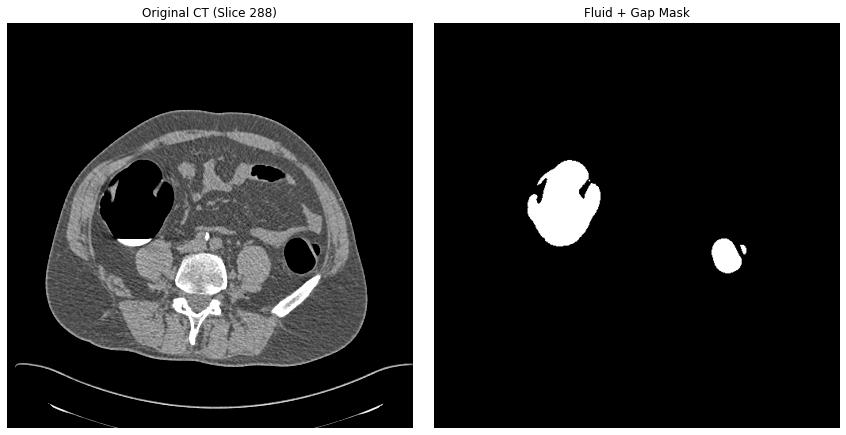

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original CT slice
axes[0].imshow(image[mid_index, :,:], cmap='gray', vmin=-300, vmax=300)
axes[0].set_title(f"Original CT (Slice {mid_index})")
axes[0].axis('off')

# CT + fluid/gap overlay
# axes[1].imshow(image[mid_index, :, :], cmap='gray', vmin=-300, vmax=300)
axes[1].imshow(filtered_mask[mid_index, :,:], cmap='gray')
axes[1].set_title("Fluid + Gap Mask")
axes[1].axis('off')

plt.tight_layout()
plt.savefig("step5.png")
plt.show()

In [ ]:
smoothed = gaussian_filter(filtered_mask.astype(float), sigma=1.0)
filtered_mask = smoothed > 0.5  # threshold back to binary

In [39]:
filtered_mask = remove_small_objects(filtered_mask, min_size=10)

In [ ]:
output_array = final_colon_mask.astype(np.uint8)  
output_image = sitk.GetImageFromArray(output_array)

# Copy metadata from original CT image
original_image = sitk.ReadImage(f"{path}{subject}_pos-{position}_scan-1_conv-sitk.mha") 
output_image.SetSpacing(original_image.GetSpacing())  # Copy voxel spacing
output_image.SetOrigin(original_image.GetOrigin())  # Copy origin
output_image.SetDirection(original_image.GetDirection())  # Copy orientation

# Save as an MHA file
sitk.WriteImage(output_image, f"{subject}_pos-{position}_scan-1_mask.mha")
print("Saved successfully!")


Saved successfully!
